In [2]:
import pandas as pd
import seaborn as sns
import duckdb
import functions as f
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


In [3]:
con = duckdb.connect("data.db")


In [4]:
oecd = con.sql("SELECT * FROM oecd").df() 
ecb = con.sql("SELECT * FROM ecb").df()         # Pandas DataFrame
eurostat = con.sql("SELECT * FROM eurostat").df()         # Pandas DataFrame


In [5]:
import pycountry

def convert_alpha2_to_alpha3(code):
    if not code or not isinstance(code, str):
        return code
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return code  # return original value if not ISO

    
eurostat['GEO'] = eurostat['GEO'].apply(convert_alpha2_to_alpha3)
eurostat['GEO'].unique()


array(['BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'IDN', 'IND', 'ITA', 'JPN',
       'KOR', 'MEX', 'RUS', 'USA', 'ZAF', 'ARG', 'FIN', 'SAU', 'G20',
       'TUR', 'UK', 'BEL', 'EST', 'LTU', 'EA19', 'EU28', 'EU27_2020',
       'AUT', 'BGR', 'CHE', 'CYP', 'CZE', 'DNK', 'EA20', 'EL', 'ESP',
       'HRV', 'HUN', 'IRL', 'LUX', 'LVA', 'MNE', 'MLT', 'NLD', 'NOR',
       'POL', 'PRT', 'ROU', 'SRB', 'SVN', 'SVK', 'ALB', 'BIH', 'MKD',
       'SWE'], dtype=object)

In [6]:
import pandas as pd

def compare_columns(df1, df2, column_name):
    """
    Compare columns between two DataFrames and print common and uncommon columns.

    Parameters:
    - df1, df2: pandas DataFrames to compare
    """
    cols1 = set(df1[column_name])
    cols2 = set(df2[column_name])

    common = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print("✅ Common columns:")
    print(sorted(common))
    print("\n🟥 Only in first DataFrame:")
    print(sorted(only_in_df1))
    print("\n🟦 Only in second DataFrame:")
    print(sorted(only_in_df2))

    return {
        "common": common,
        "only_in_df1": only_in_df1,
        "only_in_df2": only_in_df2
    }


In [7]:
col_names = compare_columns(oecd,eurostat,"GEO")

✅ Common columns:
['AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'EA19', 'EA20', 'ESP', 'EST', 'EU27_2020', 'FIN', 'FRA', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']

🟥 Only in first DataFrame:
['A5M', 'AUS', 'CHL', 'COL', 'CRI', 'G7', 'GBR', 'GRC', 'ISL', 'ISR', 'NZL', 'OECD', 'OECDE', 'OECDXEA']

🟦 Only in second DataFrame:
['ALB', 'ARG', 'BIH', 'CYP', 'EL', 'EU28', 'G20', 'MKD', 'MLT', 'MNE', 'SAU', 'SRB', 'UK']


In [8]:
def filter_geo(df, geo):
    """
    Filters a DataFrame by one or more GEO codes.

    Parameters:
    - df: pandas DataFrame
    - geo: a single GEO string or a list of GEO strings

    Returns:
    - Filtered DataFrame
    """
    if isinstance(geo, (list, tuple, set)):
        return df[df["GEO"].isin(geo)]
    else:
        return df[df["GEO"] == geo]


In [9]:
import pandas as pd

def null_counts_by_category(df, category_col, date_col='DATE'):
    """
    Calculates number of nulls and percentage of nulls in each column,
    grouped by values in a category column.

    Parameters:
    - df: pandas DataFrame
    - category_col: column name to group by (as string)
    - date_col: column used to count total entries per category (default='DATE')

    Returns:
    - DataFrame: index = category values, columns = original columns (with count and percentage),
                 plus 'avg_perct' column, sorted by 'avg_perct'.
    """
    if category_col not in df.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")

    # Count unique occurrences for each category (denominator for %)
    total_counts = df.groupby(category_col)[date_col].nunique()

    # Count nulls
    null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())
    null_counts = null_counts.drop(columns=[category_col], errors="ignore")

    # Calculate percentage of nulls for each column
    percentage_nulls = null_counts.div(total_counts, axis=0) * 100
    percentage_nulls = percentage_nulls.round(2).astype(str) + '%'

    # Calculate average percentage per row (as float)
    avg_perct = null_counts.div(total_counts, axis=0).mean(axis=1) * 100

    # Combine counts and percentages with avg_perct
    result = pd.concat([null_counts, percentage_nulls.add_suffix('_%')], axis=1)
    result['avg_perct'] = avg_perct.round(2)

    # Sort by average percentage
    result = result.sort_values(by='avg_perct')

    return result

In [10]:
null_counts_by_category(filter_geo(oecd,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,LTIR,STIR,IIR,CBAR,UEMPR,DATE_%,LTIR_%,STIR_%,IIR_%,CBAR_%,UEMPR_%,avg_perct
GEO,,,,,,,,,,,,,
LTU,0,33,9,9,38,1,0.0%,10.22%,2.79%,2.79%,11.76%,0.31%,4.64
CZE,0,87,0,0,25,1,0.0%,22.54%,0.0%,0.0%,6.48%,0.26%,4.88
USA,0,0,135,15,82,21,0.0%,0.0%,15.64%,1.74%,9.5%,2.43%,4.89
SVK,0,58,5,0,42,27,0.0%,16.48%,1.42%,0.0%,11.93%,7.67%,6.25
FIN,0,13,0,144,11,13,0.0%,2.84%,0.0%,31.44%,2.4%,2.84%,6.59
HUN,0,97,28,12,26,61,0.0%,23.66%,6.83%,2.93%,6.34%,14.88%,9.11
KOR,0,129,12,12,108,0,0.0%,30.57%,2.84%,2.84%,25.59%,0.0%,10.31
CAN,0,0,12,240,301,0,0.0%,0.0%,1.43%,28.5%,35.75%,0.0%,10.95
ESP,0,79,43,0,158,155,0.0%,12.72%,6.92%,0.0%,25.44%,24.96%,11.67


In [11]:
null_counts_by_category(filter_geo(eurostat,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,Retail_Volume,CPI,DATE_%,Retail_Volume_%,CPI_%,avg_perct
GEO,,,,,,,
DEU,0,2,0,0.0%,0.53%,0.0%,0.18
EU27_2020,0,2,0,0.0%,0.66%,0.0%,0.22
FRA,0,62,0,0.0%,16.58%,0.0%,5.53
ITA,0,74,0,0.0%,19.79%,0.0%,6.60
TUR,0,168,0,0.0%,48.28%,0.0%,16.09
KOR,0,374,0,0.0%,100.0%,0.0%,33.33
LTU,0,0,324,0.0%,0.0%,100.0%,33.33
LUX,0,0,300,0.0%,0.0%,100.0%,33.33
LVA,0,0,300,0.0%,0.0%,100.0%,33.33


In [12]:

df_merged = filter_geo(eurostat,["FRA"]).merge(filter_geo(oecd,["FRA"]), on="DATE", how="outer")
df_merged

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3


<Axes: >

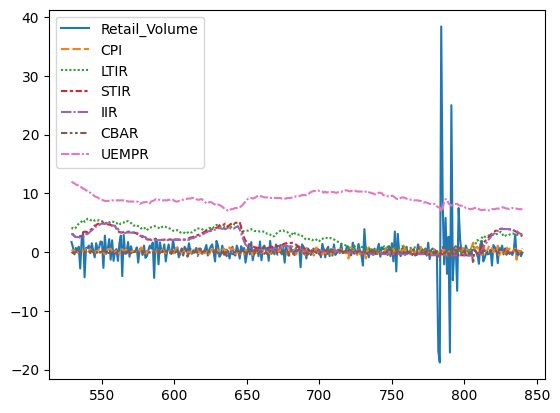

In [13]:
sns.lineplot(df_merged.dropna())

In [ ]:
df = df_merged.dropna()

In [46]:
df.columns

Index(['DATE', 'GEO_x', 'Retail_Volume', 'CPI', 'GEO_y', 'LTIR', 'STIR', 'IIR',
       'CBAR', 'UEMPR'],
      dtype='object')

In [51]:
df_test = df[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR']]

In [15]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def check_stationarity(df, signif=0.05):
    """
    Check stationarity for each numeric column using the Augmented Dickey-Fuller test.

    Parameters:
    - df: pandas DataFrame
    - signif: significance level (default: 0.05)

    Returns:
    - pd.DataFrame with columns: Test Statistic, p-value, Stationary (True/False)
    """
    results = []

    for col in df.select_dtypes(include='number').columns:
        series = df[col].dropna()
        if len(series) < 10:  # Too short for ADF test
            results.append([col, None, None, "Too few observations"])
            continue

        try:
            test_stat, p_val, _, _, _, _ = adfuller(series)
            is_stationary = p_val < signif
            results.append([col, round(test_stat, 4), round(p_val, 4), is_stationary])
        except Exception as e:
            results.append([col, None, None, f"Error: {str(e)}"])

    return pd.DataFrame(results, columns=["Column", "Test Statistic", "p-value", "Stationary"])


In [59]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

import pandas as pd

def check_stationarity_extended(df, signif=0.05, regression='c'):
    """
    Check stationarity for each numeric column using multiple tests:
    ADF, KPSS, PP, and DFGLS.

    Parameters:
    - df: pandas DataFrame with numeric columns.
    - signif: significance level (default=0.05)
    - regression: type of regression (default='c' → constant only).
                  Options: 'c' (constant), 'ct' (constant + trend), 'nc' (no constant)

    Returns:
    - pd.DataFrame: one row per column, one column per test result.
    """
    results = []

    for col in df.select_dtypes(include='number').columns:
        row = {"Column": col}
        series = df[col].dropna()

        if len(series) < 10:
            row.update({
                "ADF": "Too short",
                "KPSS": "Too short",
                "PP": "Too short",
                "DFGLS": "Too short"
            })
            results.append(row)
            continue

        # Augmented Dickey-Fuller
        try:
            adf_stat, adf_p, *_ = adfuller(series, regression=regression)
            row["ADF"] = adf_p < signif
        except Exception as e:
            row["ADF"] = f"Error: {str(e)}"

        # KPSS (note: here null = stationary)
        try:
            kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
            row["KPSS"] = kpss_p > signif  # fail to reject ⇒ stationary
        except Exception as e:
            row["KPSS"] = f"Error: {str(e)}"

        # Phillips-Perron
        try:
            pp_stat, pp_p = PhillipsPerron(series)
            row["PP"] = pp_p < signif
        except Exception as e:
            row["PP"] = f"Error: {str(e)}"


        results.append(row)

    return pd.DataFrame(results)


In [63]:
kpss(df["Retail_Volume"])

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/2199902796.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(df["Retail_Volume"])


(np.float64(0.08148264097009317),
 np.float64(0.1),
 43,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [53]:
check_stationarity(df)

,Column,Test Statistic,p-value,Stationary
0,Retail_Volume,-8.3746,0.0000,True
1,CPI,-2.6611,0.0810,False
2,LTIR,-1.2992,0.6295,False
3,STIR,-2.3185,0.1661,False
4,IIR,-2.0427,0.2682,False
5,CBAR,-7.4471,0.0000,True
6,UEMPR,-2.1697,0.2174,False


In [60]:
check_stationarity_extended(df)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_52605/35

,Column,ADF,KPSS,PP
0,Retail_Volume,True,True,Error: cannot unpack non-iterable PhillipsPerr...
1,CPI,False,True,Error: cannot unpack non-iterable PhillipsPerr...
2,LTIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
3,STIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
4,IIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
5,CBAR,True,True,Error: cannot unpack non-iterable PhillipsPerr...
6,UEMPR,False,False,Error: cannot unpack non-iterable PhillipsPerr...


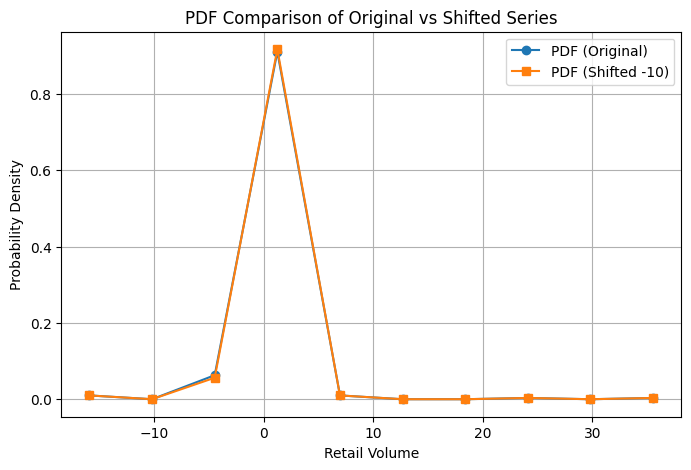

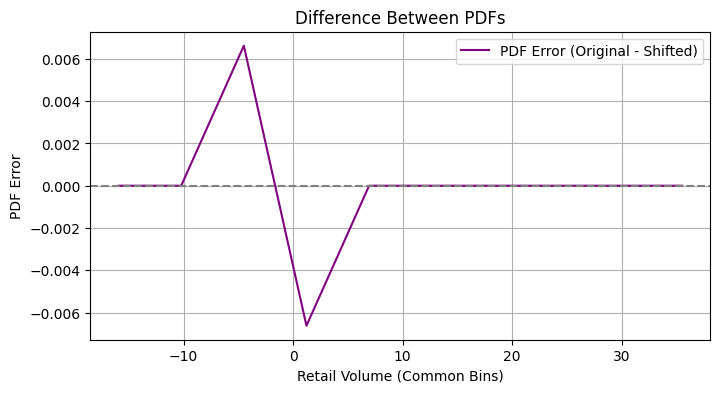

In [39]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# Drop NaNs after shifting
original = df["Retail_Volume"].dropna()
shifted = df["Retail_Volume"].shift(-10).dropna()

# Align lengths
min_len = min(len(original), len(shifted))
original = original.iloc[:min_len]
shifted = shifted.iloc[:min_len]

# Histogram and PDF for original
count, bins_count = np.histogram(original, bins=10)
pdf = count / sum(count)

# Histogram and PDF for shifted
count1, bins_count1 = np.histogram(shifted, bins=10)
pdf1 = count1 / sum(count1)

# Midpoints of bins for plotting
bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])
bin_centers1 = 0.5 * (bins_count1[1:] + bins_count1[:-1])

# Plot PDFs
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, pdf, label="PDF (Original)", marker='o')
plt.plot(bin_centers1, pdf1, label="PDF (Shifted -10)", marker='s')
plt.xlabel("Retail Volume")
plt.ylabel("Probability Density")
plt.title("PDF Comparison of Original vs Shifted Series")
plt.grid(True)
plt.legend()
plt.show()

# --- Error between PDFs ---
# Interpolate PDFs onto a common bin grid
common_bins = np.linspace(min(bin_centers[0], bin_centers1[0]),
                          max(bin_centers[-1], bin_centers1[-1]), 100)

pdf_interp = np.interp(common_bins, bin_centers, pdf)
pdf1_interp = np.interp(common_bins, bin_centers1, pdf1)
pdf_error = pdf_interp - pdf1_interp

# Plot the PDF error
plt.figure(figsize=(8, 4))
plt.plot(common_bins, pdf_error, label="PDF Error (Original - Shifted)", color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Retail Volume (Common Bins)")
plt.ylabel("PDF Error")
plt.title("Difference Between PDFs")
plt.grid(True)
plt.legend()
plt.show()


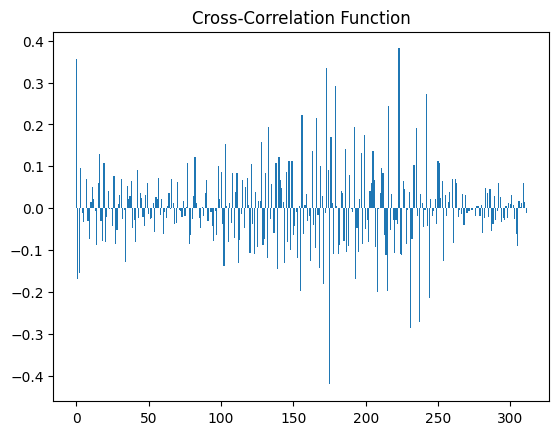

In [21]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

ccf_vals = ccf(df["Retail_Volume"],df["CBAR"])
plt.bar(range(len(ccf_vals)), ccf_vals)
plt.title("Cross-Correlation Function")
plt.show()


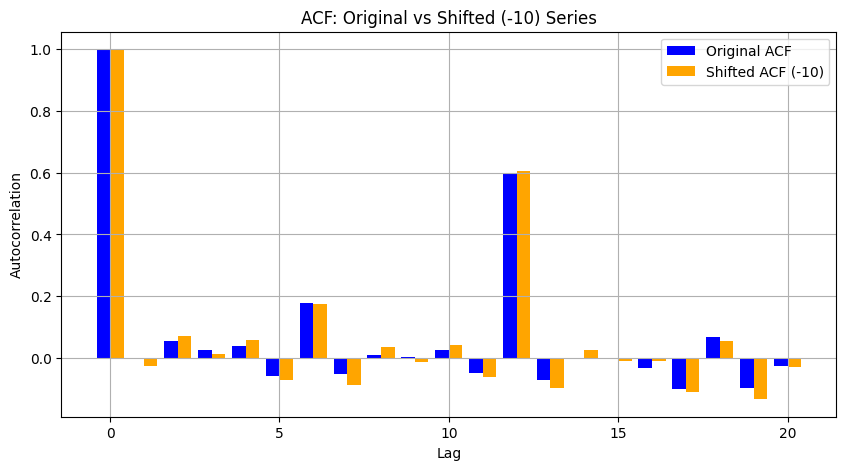

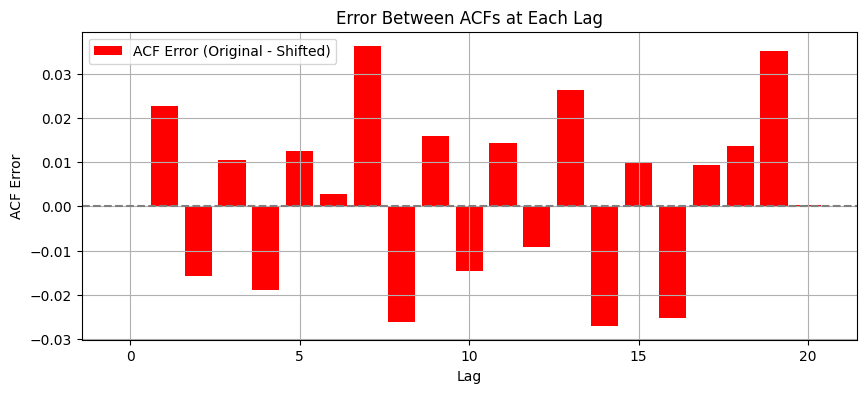

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf

# Drop NaNs
series = df["CPI"].dropna()
series_shifted = df["CPI"].shift(-10).dropna()

# Align lengths
min_len = min(len(series), len(series_shifted))
series = series.iloc[:min_len]
series_shifted = series_shifted.iloc[:min_len]

# Compute ACFs
nlags = 20
acf_vals = acf(series, nlags=nlags)
acf_shifted_vals = acf(series_shifted, nlags=nlags)

# Compute error
acf_error = acf_vals - acf_shifted_vals
lags = range(len(acf_vals))

# --- Plot 1: ACF Comparison ---
bar_width = 0.4
plt.figure(figsize=(10, 5))
plt.bar([l - bar_width/2 for l in lags], acf_vals, width=bar_width, label='Original ACF', color='blue')
plt.bar([l + bar_width/2 for l in lags], acf_shifted_vals, width=bar_width, label='Shifted ACF (-10)', color='orange')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("ACF: Original vs Shifted (-10) Series")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: ACF Error ---
plt.figure(figsize=(10, 4))
plt.bar(lags, acf_error, color='red', label='ACF Error (Original - Shifted)')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Lag")
plt.ylabel("ACF Error")
plt.title("Error Between ACFs at Each Lag")
plt.grid(True)
plt.legend()
plt.show()


In [19]:
ccf(df["Retail_Volume"],df["CBAR"],nlags=25)

array([ 0.35621877, -0.16957292, -0.15417371,  0.09549172, -0.01081872,
       -0.03424908,  0.00061954,  0.07079942, -0.03022895, -0.07472424,
        0.01515022,  0.05068723,  0.02215433, -0.00766449, -0.0873092 ,
        0.05947697,  0.12890003, -0.03006758, -0.07919181,  0.10815286,
       -0.08101543, -0.02124769,  0.03997289, -0.0012177 , -0.00129118])

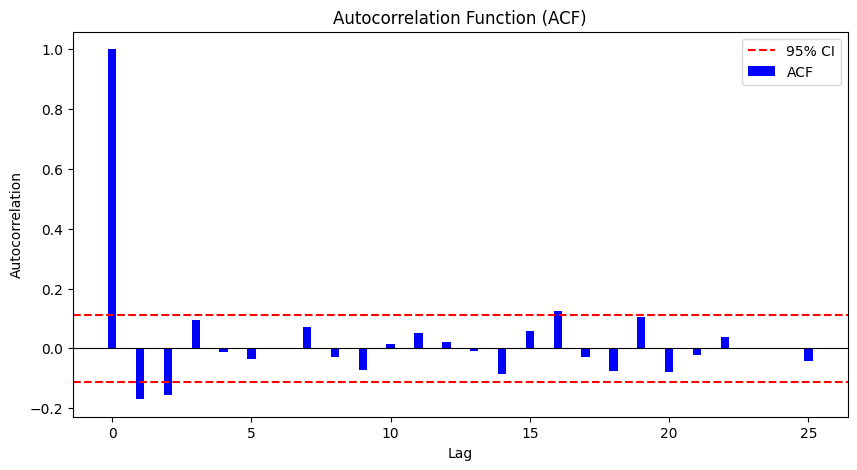

In [133]:
f.ccf_plot(df["Retail_Volume"],df["CBAR"],nlags=25)

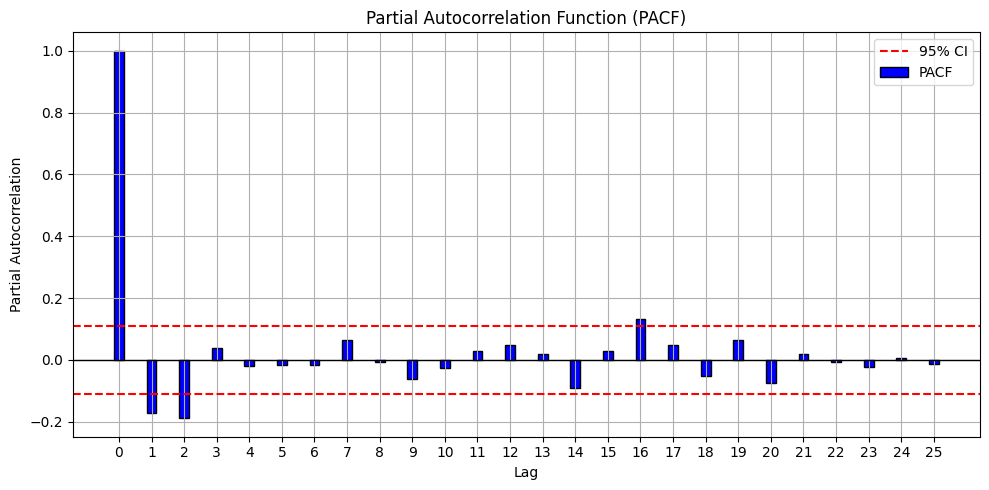

In [134]:
f.pccf_plot(df["Retail_Volume"],df["CBAR"],nlags=25)

In [128]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_granger_causality_pvalues(df, maxlag, variables, alpha=0.05, verbose=False):
    """
    Run grangercausalitytests and plot p-values for each lag.

    Parameters:
    - df: DataFrame with two columns [Y, X] where X is tested as a cause of Y
    - maxlag: maximum lag to test
    - variables: tuple (Y, X) – names of the dependent and independent variables
    - alpha: significance level for rejection
    - verbose: if True, prints full test output
    """
    y_col, x_col = variables
    test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=maxlag, verbose=verbose)

    p_values = []
    for lag in range(1, maxlag + 1):
        p_val = test_result[lag][0]['ssr_ftest'][1]  # extract p-value from F-test
        p_values.append(p_val)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, maxlag + 1), p_values, color='skyblue')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance level ({alpha})')
    plt.xticks(range(1, maxlag + 1))
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title(f"Granger Causality Test p-values: Does {x_col} → {y_col}?")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return p_values


/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


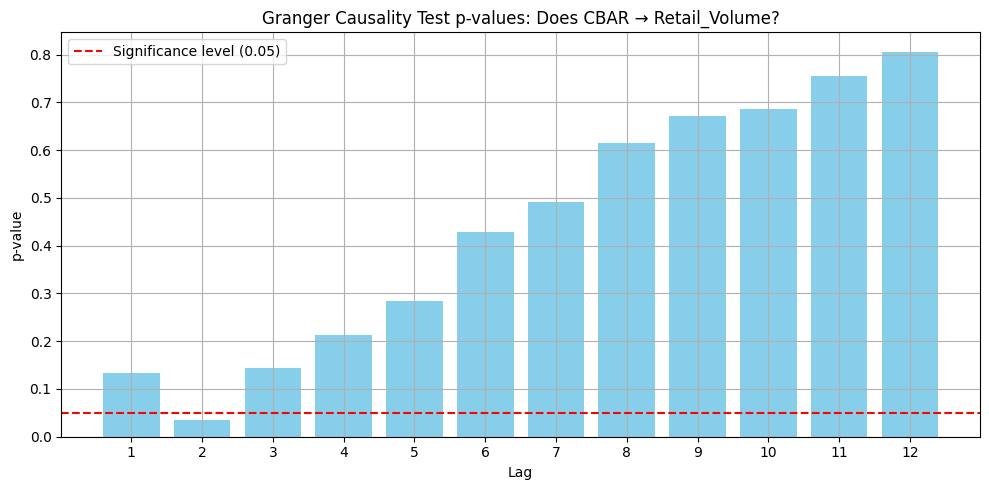

[np.float64(0.13447662571049793),
 np.float64(0.03481445659070169),
 np.float64(0.1446497703122907),
 np.float64(0.2123352017320653),
 np.float64(0.2840752374728696),
 np.float64(0.42926942544669255),
 np.float64(0.4916615881664299),
 np.float64(0.6145688602342527),
 np.float64(0.6706612556518275),
 np.float64(0.6854662796906092),
 np.float64(0.756412117271022),
 np.float64(0.8065555190175816)]

In [130]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

plot_granger_causality_pvalues(df, 12, variables=('Retail_Volume','CBAR'))


In [132]:
from statsmodels.tsa.stattools import coint

# Two time series: y and x (non-stationary)
# For example: y = GDP, x = Unemployment Rate
score, pvalue, _ = coint(df["Retail_Volume"],df["CBAR"])

print("Cointegration Test p-value:", pvalue)

if pvalue < 0.05:
    print("✅ Series are cointegrated.")
else:
    print("❌ No cointegration detected.")


Cointegration Test p-value: 3.621212796266345e-10
✅ Series are cointegrated.


In [124]:
corr_test = df[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR','CBAR', 'UEMPR']]

<Axes: >

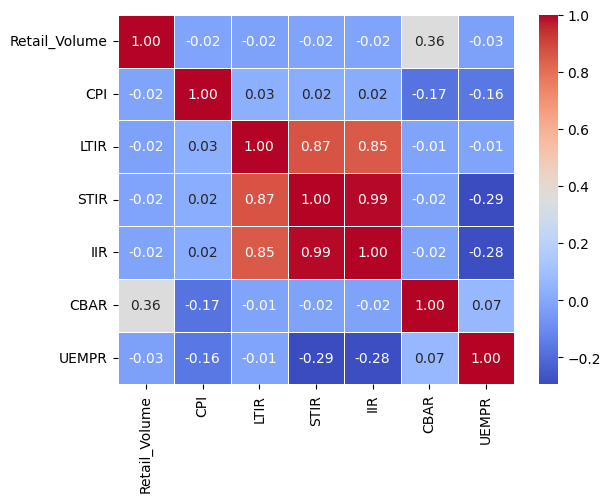

In [126]:
matrix = corr_test.corr()
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
